The purpose of this notebook is to check how many tokens we need for optimal language classification

In [1]:
import os
import logging
import pandas as pd
import numpy as np
import gc
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)


raw_dir = "/home/peterr/macocu/taskB/data/raw"
interim_dir = "/home/peterr/macocu/taskB/data/interim"
final_dir = "/home/peterr/macocu/taskB/data/final"

In [2]:
import parse
from typing import List


def get_N_tokens(N=5000, path="/home/peterr/macocu/taskB/task4/toy_tokens.csv") -> set:

    df = pd.read_csv("toy_tokens.csv", index_col=0)
    NUM_FEATS = N

    for column in df.columns:
        new_column_name = column + "_f"
        corpus_size = df[column].sum()
        df[new_column_name] = df[column] * 1e6 / corpus_size

    N = 1

    df["HR_SR"] = (df["hrwac_head_pp_f"] + N) / (df["srwac_head_pp_f"] + N)
    df["SR_HR"] = (df["srwac_head_pp_f"] + N) / (df["hrwac_head_pp_f"] + N)

    df["HR_CNR"] = (df["hrwac_head_pp_f"] + N) / (df["cnrwac_head_pp_f"] + N)
    df["CNR_HR"] = (df["cnrwac_head_pp_f"] + N) / (df["hrwac_head_pp_f"] + N)

    df["HR_BS"] = (df["hrwac_head_pp_f"] + N) / (df["bswac_head_pp_f"] + N)
    df["BS_HR"] = (df["bswac_head_pp_f"] + N) / (df["hrwac_head_pp_f"] + N)

    df["BS_SR"] = (df["bswac_head_pp_f"] + N) / (df["srwac_head_pp_f"] + N)
    df["SR_BS"] = (df["srwac_head_pp_f"] + N) / (df["bswac_head_pp_f"] + N)

    df["BS_CNR"] = (df["bswac_head_pp_f"] + N) / (df["cnrwac_head_pp_f"] + N)
    df["CNR_BS"] = (df["cnrwac_head_pp_f"] + N) / (df["bswac_head_pp_f"] + N)

    df["CNR_SR"] = (df["cnrwac_head_pp_f"] + N) / (df["srwac_head_pp_f"] + N)
    df["SR_CNR"] = (df["srwac_head_pp_f"] + N) / (df["cnrwac_head_pp_f"] + N)

    combos = ['HR_SR', 'SR_HR', 'HR_CNR', 'CNR_HR', 'HR_BS', 'BS_HR',
              'BS_SR', 'SR_BS', 'BS_CNR', 'CNR_BS', 'CNR_SR', 'SR_CNR']

    important_features = set()

    for lang_comb in combos:
        s = df[lang_comb].sort_values(ascending=False)
        current_features = s.index[:NUM_FEATS].values
        important_features = important_features.union(set(current_features))
    try:
        important_features.remove(np.nan)
    except KeyError:
        pass
    return important_features


def read_and_split_file(path: str) -> List[str]:
    texts = list()
    chunk = ""
    with open(path, "r") as f:
        content = f.readlines()
    for line in content:
        # Handle splits
        if line == "\n":
            texts.append(chunk)
            chunk = ""
        # Filter only lowercase alphabetical words:
        from utils import is_alpha
        line = line.replace("\n", " ")
        words = [w if is_alpha(w) else " " for w in line.split(" ")]
        chunk += " ".join(words)
    return texts


texts, labels = list(), list()

files = [
    "bswac_tail_pp",
    "cnrwac_tail_pp",
    "hrwac_tail_pp",
    "srwac_tail_pp"]

langs = ["bs", "me", "hr", "sr"]

for file, lang in zip(files, langs):
    full_path = os.path.join(interim_dir, file)
    current_texts = read_and_split_file(full_path)
    len_cur_texts = len(current_texts)
    texts.extend(current_texts)
    labels.extend([lang]*len_cur_texts)

train = pd.DataFrame(data={"text": texts, "labels": labels})

del texts, labels

SETimes = list()
for split in ["train", "test", "dev"]:
    with open(os.path.join(final_dir, f"{split}.fasttxt"), "r") as f:
        lines = f.readlines()
        SETimes.extend(lines)

p = parse.compile("__label__{lang} {text}")
langs = list()
texts = list()

for line in SETimes:
    results = p.parse(line)
    if not results:
        logging.error(f"Error parsing line {line}")
        continue
    langs.append(results["lang"])
    texts.append(results["text"])

eval_df = pd.DataFrame(data={"text": texts, "labels": langs})

del texts, langs, SETimes, line, lines, p


def get_stats(N: int):
    import gc
    import time
    from sklearn.naive_bayes import GaussianNB
    from sklearn.feature_extraction.text import CountVectorizer
    gc.collect()
    start = time.time()
    vectorizer = CountVectorizer(
        vocabulary=get_N_tokens(N), lowercase=True, binary=True)

    train_vectors = vectorizer.fit_transform(train.text)
    train_labels = train.labels

    test_vectors = vectorizer.fit_transform(eval_df.text)
    y_true = eval_df.labels

    clf = GaussianNB()
    train_start = time.time()
    clf.fit(train_vectors.toarray(), train_labels)
    predict_start = time.time()
    y_pred = clf.predict(test_vectors.toarray())
    predict_end = time.time()
    from sklearn.metrics import f1_score, ConfusionMatrixDisplay, confusion_matrix, accuracy_score
    import matplotlib.pyplot as plt
    LABELS = ["hr", "bs", "sr",  "me"]
    LABELS = ["hr", "bs", "sr",  "me"]

    macro = f1_score(y_true, y_pred, labels=LABELS, average="macro")
    micro = f1_score(y_true, y_pred, labels=LABELS,  average="micro")
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=LABELS)
    return {
        "N": N,
        "microF1": micro,
        "macroF1": macro,
        "accuracy": acc,
        "overall_time": time.time() - start,
        "cm": cm,
        "vectorizer_fitting": train_start - start,
        "training_time": predict_start - train_start,
        "predicting_time": predict_end - predict_start
    }


In [11]:

results = list()
Ns = np.logspace(1, 4, 40, dtype=np.int)
for N in Ns:
    try:
        gc.collect()
        logging.info(f"{N=}")
        cur_result = get_stats(N)
        results.append(cur_result)
    except Exception as e:
        logging.error(f"For {N=} got Exception: {e}")


2022-01-04 15:19:56,083 - N=10
2022-01-04 15:20:46,788 - N=11
2022-01-04 15:21:36,979 - N=14
2022-01-04 15:22:27,447 - N=17
2022-01-04 15:23:17,874 - N=20
2022-01-04 15:24:07,986 - N=24
2022-01-04 15:24:58,469 - N=28
2022-01-04 15:25:49,224 - N=34
2022-01-04 15:26:40,762 - N=41
2022-01-04 15:27:32,022 - N=49
2022-01-04 15:28:23,945 - N=58
2022-01-04 15:29:16,208 - N=70
2022-01-04 15:30:09,420 - N=83
2022-01-04 15:31:03,687 - N=100
2022-01-04 15:31:58,420 - N=119
2022-01-04 15:32:53,897 - N=142
2022-01-04 15:33:50,603 - N=170
2022-01-04 15:34:48,468 - N=203
2022-01-04 15:35:47,284 - N=242
2022-01-04 15:36:47,898 - N=289
2022-01-04 15:37:51,261 - N=345
2022-01-04 15:38:56,468 - N=412
2022-01-04 15:40:03,728 - N=492
2022-01-04 15:41:14,031 - N=587
2022-01-04 15:42:27,767 - N=701
2022-01-04 15:43:45,690 - N=837
2022-01-04 15:45:08,709 - N=1000
2022-01-04 15:46:36,558 - N=1193
2022-01-04 15:48:11,429 - N=1425
2022-01-04 15:49:54,288 - N=1701
2022-01-04 15:51:43,900 - N=2030
2022-01-04 15:53

In [12]:
rezdf = pd.DataFrame(data=results)
rezdf.index = rezdf.N
rezdf = rezdf.drop(columns=["N"])
rezdf = rezdf.sort_index()
rezdf.tail()


,microF1,macroF1,accuracy,overall_time,cm,vectorizer_fitting,training_time,predicting_time
N,,,,,,,,
3455,0.806189,0.599706,0.806189,153.840967,"[[55, 33, 0, 1], [3, 59, 13, 0], [1, 16, 376, ...",51.086726,102.401844,0.346925
4124,0.811075,0.599624,0.811075,170.532794,"[[56, 32, 0, 1], [2, 59, 14, 0], [0, 14, 379, ...",51.473928,118.652050,0.401436
4923,0.814332,0.600180,0.814332,192.274621,"[[51, 33, 5, 0], [1, 64, 10, 0], [0, 13, 381, ...",51.820584,139.973509,0.475032
5878,0.811075,0.601564,0.811075,212.683986,"[[50, 36, 3, 0], [1, 63, 11, 0], [1, 13, 380, ...",52.182053,159.936571,0.559884
7017,0.789902,0.566760,0.789902,239.325222,"[[44, 43, 2, 0], [1, 64, 10, 0], [1, 20, 373, ...",52.755535,185.925266,0.638930


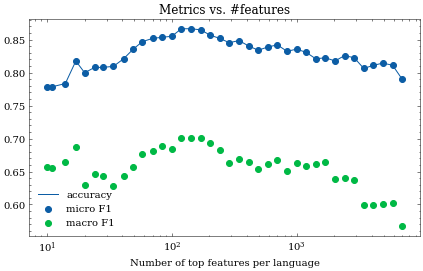

In [13]:
import matplotlib.pyplot as plt
plt.style.use(["science", "no-latex"])

plt.figure(figsize=(7, 4))
plt.scatter(rezdf.index, rezdf["microF1"],label="micro F1")

plt.scatter(rezdf.index, rezdf["macroF1"],label="macro F1")

plt.plot(rezdf.index, rezdf["accuracy"],label="accuracy")
plt.legend()
plt.title("Metrics vs. #features")
plt.xlabel("Number of top features per language")
plt.semilogx()
plt.savefig("images/14_metrics.png")
plt.show()

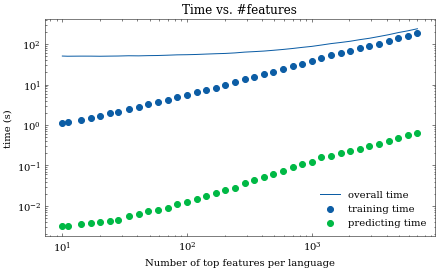

In [14]:
import matplotlib.pyplot as plt
plt.style.use(["science", "no-latex"])

plt.figure(figsize=(7, 4))
plt.scatter(rezdf.index, rezdf["training_time"],label="training time")

plt.scatter(rezdf.index, rezdf["predicting_time"],label="predicting time")

plt.plot(rezdf.index, rezdf["overall_time"],label="overall time")
plt.legend()
plt.title("Time vs. #features")
plt.xlabel("Number of top features per language")
plt.ylabel("time (s)")
plt.semilogx()
plt.semilogy()
plt.savefig("images/14_time.png")
plt.show()

In [15]:
rezdf.to_csv("14_results_SETimes.csv")

## Repeating the experiment with evaluation on Twitter data

Evaluation dataset will be overwritten with twitter dataset and the experiment will be rerun.

In [7]:
import pickle

with open("/home/peterr/macocu/taskB/data/final/twitter_full_ds.pickle", "rb") as f:
    twitter_ds = pickle.load(f)

users = twitter_ds.keys()
languages = [twitter_ds[user]["language"] for user in users]
tweets = [" ".join(twitter_ds[user]["tweets"]) for user in users]

eval_df = pd.DataFrame(data={"text": tweets, "labels": languages})

del users, languages, tweets, twitter_ds


results_tw = list()
Ns = np.logspace(1, 4, 40, dtype=np.int)
for N in Ns:
    try:
        gc.collect()
        logging.info(f"{N=}")
        cur_result = get_stats(N)
        logging.info(f"Done!")
        results_tw.append(cur_result)
    except Exception as e:
        logging.error(f"For {N=} got Exception: {e}")


2022-01-04 13:12:13,846 - N=10
2022-01-04 13:13:04,437 - Done!
2022-01-04 13:13:04,489 - N=11
2022-01-04 13:13:54,705 - Done!
2022-01-04 13:13:54,759 - N=14
2022-01-04 13:14:45,076 - Done!
2022-01-04 13:14:45,127 - N=17
2022-01-04 13:15:35,932 - Done!
2022-01-04 13:15:35,982 - N=20
2022-01-04 13:16:26,238 - Done!
2022-01-04 13:16:26,289 - N=24
2022-01-04 13:17:16,994 - Done!
2022-01-04 13:17:17,045 - N=28
2022-01-04 13:18:08,011 - Done!
2022-01-04 13:18:08,062 - N=34
2022-01-04 13:18:59,438 - Done!
2022-01-04 13:18:59,489 - N=41
2022-01-04 13:19:50,967 - Done!
2022-01-04 13:19:51,017 - N=49
2022-01-04 13:20:43,115 - Done!
2022-01-04 13:20:43,168 - N=58
2022-01-04 13:21:35,721 - Done!
2022-01-04 13:21:35,773 - N=70
2022-01-04 13:22:29,280 - Done!
2022-01-04 13:22:29,337 - N=83
2022-01-04 13:23:24,324 - Done!
2022-01-04 13:23:24,382 - N=100
2022-01-04 13:24:19,280 - Done!
2022-01-04 13:24:19,338 - N=119
2022-01-04 13:25:15,048 - Done!
2022-01-04 13:25:15,100 - N=142
2022-01-04 13:26:11,8

In [8]:
rezdf = pd.DataFrame(data=results_tw)
rezdf.index = rezdf.N
rezdf = rezdf.drop(columns=["N"])
rezdf = rezdf.sort_index()
rezdf.tail()

,microF1,macroF1,accuracy,overall_time,cm,vectorizer_fitting,training_time,predicting_time
N,,,,,,,,
3455,0.806189,0.599706,0.806189,153.087175,"[[55, 33, 0, 1], [3, 59, 13, 0], [1, 16, 376, ...",50.505114,102.232353,0.344258
4124,0.811075,0.599624,0.811075,167.997443,"[[56, 32, 0, 1], [2, 59, 14, 0], [0, 14, 379, ...",50.983147,116.610621,0.398180
4923,0.814332,0.600180,0.814332,188.176483,"[[51, 33, 5, 0], [1, 64, 10, 0], [0, 13, 381, ...",51.462990,136.242051,0.465963
5878,0.811075,0.601564,0.811075,211.895812,"[[50, 36, 3, 0], [1, 63, 11, 0], [1, 13, 380, ...",52.092442,159.251595,0.546209
7017,0.789902,0.566760,0.789902,246.183793,"[[44, 43, 2, 0], [1, 64, 10, 0], [1, 20, 373, ...",52.834694,192.694708,0.647221


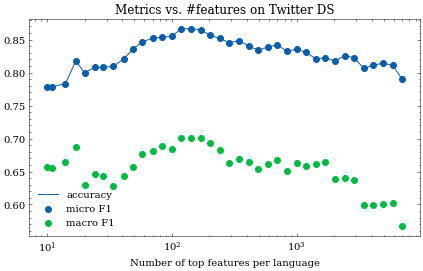

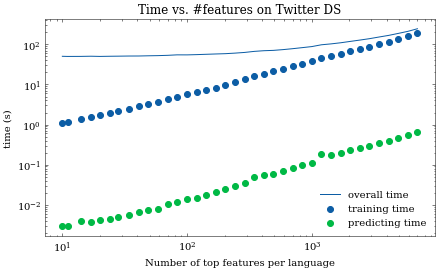

In [9]:
import matplotlib.pyplot as plt
plt.style.use(["science", "no-latex"])

plt.figure(figsize=(7, 4))
plt.scatter(rezdf.index, rezdf["microF1"],label="micro F1")

plt.scatter(rezdf.index, rezdf["macroF1"],label="macro F1")

plt.plot(rezdf.index, rezdf["accuracy"],label="accuracy")
plt.legend()
plt.title("Metrics vs. #features on Twitter DS")
plt.xlabel("Number of top features per language")
plt.semilogx()
plt.savefig("images/14_metrics_twitter.png")
plt.show()

plt.figure(figsize=(7, 4))
plt.scatter(rezdf.index, rezdf["training_time"],label="training time")

plt.scatter(rezdf.index, rezdf["predicting_time"],label="predicting time")

plt.plot(rezdf.index, rezdf["overall_time"],label="overall time")
plt.legend()
plt.title("Time vs. #features on Twitter DS")
plt.xlabel("Number of top features per language")
plt.ylabel("time (s)")
plt.semilogx()
plt.semilogy()
plt.savefig("images/14_time_twitter.png")
plt.show()

rezdf.to_csv("14_results_twitter.csv")

In [10]:
rezdf.to_csv("14_results_twitter_2.csv")